## Notebook for Joanito-2022 data processing 
### Developed by: Anna Maguza

### Institute of Computational Biology - Computational Health Centre - Hemlholtz Munich

### 18 October 2022

#### Load packages

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as an
import h5py

In [2]:
import scrublet

In [3]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

#### Setup Cells

In [4]:
%matplotlib inline

In [5]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/Users/anna.maguza/miniconda3/envs/scanpy_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.9.1 pandas==1.3.5 scikit-learn==1.2.2 statsmodels==0.13.5 pynndescent==0.5.8


#### Upload Data

In [6]:
#Data Upload (csv)
Epithelial_meta = pd.read_csv('/Users/anna.maguza/Desktop/Data/Gut_project/Joanito_cancer/Joanito_cancer_dataset/Epithelial_metadata.csv', index_col=[1])
Nonepithelial_meta = pd.read_csv('/Users/anna.maguza/Desktop/Data/Gut_project/Joanito_cancer/Joanito_cancer_dataset/NonEpithelial_metadata.csv', index_col=[1])

In [7]:
#Data Upload (csv)
Patientmeta = pd.read_csv('/Users/anna.maguza/Desktop/Data/Gut_project/Joanito_cancer/Joanito_cancer_dataset/patient_clinical_information.csv', index_col=[1], encoding='cp1252')

### For anndata==0.8.0 and higher

In [8]:
def read_v3_10x_h5_mod(filename, *, start=None):
    """
    Read hdf5 file from Cell Ranger v3 or later versions.
    """
    with h5py.File(str(filename), 'r') as f:
        try:
            dsets = {}
            sc.readwrite._collect_datasets(dsets, f["matrix"])
            from scipy.sparse import csr_matrix

            M, N = dsets['shape']
            data = dsets['data']
            if dsets['data'].dtype == np.dtype('int32'):
                data = dsets['data'].view('float32')
                data[:] = dsets['data']
            matrix = csr_matrix(
                (data, dsets['indices'], dsets['indptr']),
                shape=(N, M),
            )
            adata = an.AnnData(
                matrix,
                obs=dict(obs_names=dsets['barcodes'].astype(str)),
                var=dict(
                    var_names=dsets['name'].astype(str),
                    feature_types=dsets['feature_type'].astype(str),
                    genome=dsets['genome'].astype(str),
                ),
            )
            return adata
        except KeyError:
            raise Exception('File is missing one or more required datasets.')

### For scanpy==1.6.0 and anndata==0.7.4 

In [ ]:
def _collect_datasets(dsets: dict, group: h5py.Group):
    for k, v in group.items():
        if isinstance(v, h5py.Dataset):
            dsets[k] = v[()]
        else:
            _collect_datasets(dsets, v)

In [ ]:
def read_v3_10x_h5_mod2(filename, *, start=None):
    """
    Read hdf5 file from Cell Ranger v3 or later versions.
    """
    with h5py.File(str(filename), 'r') as f:
        try:
            dsets = {}
            _collect_datasets(dsets, f["matrix"])

            from scipy.sparse import csr_matrix

            M, N = dsets['shape']
            data = dsets['data']
            if dsets['data'].dtype == np.dtype('int32'):
                data = dsets['data'].view('float32')
                data[:] = dsets['data']
            matrix = csr_matrix(
                (data, dsets['indices'], dsets['indptr']),
                shape=(N, M),
            )
            adata = an.AnnData(
                matrix,
                obs=dict(obs_names=dsets['barcodes'].astype(str)),
                var=dict(
                    var_names=dsets['name'].astype(str),
                    feature_types=dsets['feature_type'].astype(str),
                    genome=dsets['genome'].astype(str),
                ),
            )
            return adata
        except KeyError:
            raise Exception('File is missing one or more required datasets.')

In [9]:
# Please use read_v3_10x_h5_mod2 for earlier scanpy and anndata versions and read_v3_10x_h5_mod for anndata later than 0.8.0
Epithelian_data = read_v3_10x_h5_mod('/Users/anna.maguza/Desktop/Data/Gut_project/Joanito_cancer/Joanito_cancer_dataset/Epithelial_Count_matrix.h5')

/var/folders/gb/wwnzrh015q9dns5cmsc3xcjsxglkqz/T/ipykernel_59657/1635666716.py:20: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = an.AnnData(


In [10]:
# Please use read_v3_10x_h5_mod2 for earlier scanpy and anndata versions and read_v3_10x_h5_mod for anndata later than 0.8.0
Nonepithelian_data = read_v3_10x_h5_mod('/Users/anna.maguza/Desktop/Data/Gut_project/Joanito_cancer/Joanito_cancer_dataset/NonEpithelial_Count_matrix.h5')

/var/folders/gb/wwnzrh015q9dns5cmsc3xcjsxglkqz/T/ipykernel_59657/1635666716.py:20: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = an.AnnData(


### Create metadata

In [11]:
# Merge Epithelial_meta and Patientmeta by patient.ID 
Epithelial_meta = Epithelial_meta.merge(Patientmeta, left_on='patient.ID', right_on='patient.ID', how='left')

# Merge Nonepithelial_meta and Patientmeta by patient.ID 
Nonepithelial_meta = Nonepithelial_meta.merge(Patientmeta, left_on='patient.ID', right_on='patient.ID', how='left')

### Create epithelial anndata

In [12]:
epithelial_anndata = an.AnnData(X = Epithelian_data.X, obs = Epithelian_data.obs, var=Epithelian_data.var)

In [13]:
# Make 'cell.ID' column as index in Epithelial_meta
Epithelial_meta = Epithelial_meta.set_index('cell.ID')

#Copy index column as a separate column
Epithelial_meta['cell_ID'] = Epithelial_meta.index

In [14]:
# Concatenate epithelial_anndata.obs and Epithelial_meta by index
epithelial_anndata.obs = pd.concat([epithelial_anndata.obs, Epithelial_meta], axis=1)

### Create non-epithelial anndata

In [15]:
nonepithelial_anndata = an.AnnData(X = Nonepithelian_data.X, obs = Nonepithelian_data.obs, var=Nonepithelian_data.var)

In [16]:
# Make 'cell.ID' column as index in Epithelial_meta
Nonepithelial_meta = Nonepithelial_meta.set_index('cell.ID')

#Copy index column as a separate column
Nonepithelial_meta['cell_ID'] = Nonepithelial_meta.index

In [17]:
# Concatenate epithelial_anndata.obs and Epithelial_meta by index
nonepithelial_anndata.obs = pd.concat([nonepithelial_anndata.obs, Nonepithelial_meta], axis=1)

#### Preparing anndata file (var and X)

In [18]:
#Concatenate 2 anndata files (nonepithelial and epithelian)
Joanito_2022 = nonepithelial_anndata.concatenate(epithelial_anndata)

/Users/anna.maguza/miniconda3/envs/scanpy_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [19]:
del Nonepithelian_data, Epithelian_data, epithelial_anndata, nonepithelial_anndata

In [20]:
X_is_raw(Joanito_2022)

True

In [21]:
Joanito_2022.raw = Joanito_2022

#### Rename obs

In [22]:
# Rename columns in obs 
Joanito_2022.obs = Joanito_2022.obs.rename(columns={"sample.ID": "Sample_ID"})
Joanito_2022.obs = Joanito_2022.obs.rename(columns={"patient.ID": "Donor_ID"})
Joanito_2022.obs = Joanito_2022.obs.rename(columns={"cell.type": "Cell_Type"})
#Joanito_2022s.obs = Joanito_2022.obs.rename(columns={"sample.origin": "Diagnosis"})
Joanito_2022.obs = Joanito_2022.obs.rename(columns={"Sidedness": "Side"})
Joanito_2022.obs = Joanito_2022.obs.rename(columns={"Site": "Location"})
Joanito_2022.obs = Joanito_2022.obs.rename(columns={"Age at recruitment": "Tumor Stage"})
Joanito_2022.obs = Joanito_2022.obs.rename(columns={"Gender": "Sex"})
Joanito_2022.obs['Age_group'] = 'Adult'
Joanito_2022.obs['Study_name'] = 'Joanito, 2022'
#Joanito_2022.obs = Joanito_2022.obs.rename(columns={"percent.mt": "pct_counts_mito"})
#del Joanito_2022.obs.obs['nFeature_RNA']

In [23]:
def diagnosis_mapping(label):
    if label.startswith('T1'):
        return 'Colorectal cancer, Stage I'
    elif label.startswith('T2'):
        return 'Colorectal cancer, Stage II'
    elif label.startswith('T3'):
        return 'Colorectal cancer, Stage III'
    elif label.startswith('T4'):
        return 'Colorectal cancer, Stage IV'
    elif label.startswith('mpT3'):
        return 'Colorectal cancer, Stage mpIII'
    elif label.startswith('pT1'):
        return 'Colorectal cancer, Stage pI'
    elif label.startswith('pT2'):
        return 'Colorectal cancer, Stage pII'
    elif label.startswith('pT3'):
        return 'Colorectal cancer, Stage pIII'
    elif label.startswith('pT4'):
        return 'Colorectal cancer, Stage pIV'
    elif label.startswith('ypT3'):
        return 'Colorectal cancer, Stage ypIII'
    else:
        return label  # leave the label unchanged if it doesn't match any of the above
    

Joanito_2022.obs['Diagnosis'] = Joanito_2022.obs['Stage TNM']

Joanito_2022.obs['Diagnosis'] = Joanito_2022.obs['Diagnosis'].apply(diagnosis_mapping)


In [24]:
Joanito_2022.obs['Diagnosis'].value_counts()

Colorectal cancer, Stage III      212615
Colorectal cancer, Stage IV       113542
Colorectal cancer, Stage pIII      16645
Colorectal cancer, Stage pIV        8696
Colorectal cancer, Stage II         7062
Colorectal cancer, Stage pI         4224
Colorectal cancer, Stage pII        3159
Colorectal cancer, Stage mpIII      3034
Colorectal cancer, Stage ypIII      2769
Colorectal cancer, Stage I          1312
Name: Diagnosis, dtype: int64

In [25]:
Joanito_2022.obs['Sex'].replace({'M': 'Male', 
                                        'F': 'Female'}, inplace=True)

In [26]:
Joanito_2022.obs['Cell_Type'].replace({'T_NK': 'T cells', 
                                        'PlasmaB': 'Plasma cells',
                                        'Fibroblast': 'Mesenchymal',
                                        'B': 'B cells'}, inplace=True)

In [27]:
# Calculate quality metrics for cancer dataset
sc.pp.calculate_qc_metrics(Joanito_2022, percent_top=None, log1p=False, inplace=True)

In [28]:
# Make a new column "Library_Preparation_Protocol" in Cancer_adata_raw.obs and if Cancer_adata_raw.obs[dataset_x] == 'SMC' then fill it with "10X 3' v2"
# if Cancer_adata_raw.obs[dataset_x] == 'CRC-SG2' then fill it with "10X 3' v3"
# if Cancer_adata_raw.obs[dataset_x] =='KUL3' then fill it with "10X 3' v2"
# if Cancer_adata_raw.obs[dataset_x] =='KUL5' then fill it with "5'"
# if dCancer_adata_raw.obs[dataset_x] == 'CRC-SG1' then fill it with "5'"

# Create a new column "Library_Preparation_Protocol" in Cancer_adata_raw.obs
Joanito_2022.obs['Library_Preparation_Protocol'] = ""

# Iterate over each row and assign the corresponding protocol value
for idx, row in Joanito_2022.obs.iterrows():
    dataset_x = row['dataset_x']
    if dataset_x == 'SMC':
        Joanito_2022.obs.at[idx, 'Library_Preparation_Protocol'] = "10x 3' v2"
    elif dataset_x == 'CRC-SG2':
        Joanito_2022.obs.at[idx, 'Library_Preparation_Protocol'] = "10x 3' v3"
    elif dataset_x == 'KUL3':
        Joanito_2022.obs.at[idx, 'Library_Preparation_Protocol'] = "10x 3' v2"
    elif dataset_x == 'KUL5':
        Joanito_2022.obs.at[idx, 'Library_Preparation_Protocol'] = "10x 5' v1"
    elif dataset_x == 'CRC-SG1':
        Joanito_2022.obs.at[idx, 'Library_Preparation_Protocol'] = "10x 5' v1"

In [29]:
Joanito_2022.obs['Library_Preparation_Protocol'].value_counts()

10x 5' v1    249668
10x 3' v2     85295
10x 3' v3     38095
Name: Library_Preparation_Protocol, dtype: int64

In [30]:
#Saving the final anndata file
Joanito_2022.write('/Users/anna.maguza/Desktop/Data/Gut_project/Joanito_cancer/anndata/Joanito_raw_anndata_all_cells.h5ad')

In [31]:
del Epithelial_meta, Nonepithelial_meta, Patientmeta

### Doublets Identification

In [6]:
input = '/Users/anna.maguza/Desktop/Data/Gut_project/Joanito_cancer/anndata/Joanito_raw_anndata_all_cells.h5ad'
Joanito_2022 = sc.read_h5ad(input)

In [32]:
# Filter only tumor cells
Joanito_2022 = Joanito_2022[Joanito_2022.obs['sample.origin'] == 'Tumor']

In [33]:
scrub = scrublet.Scrublet(Joanito_2022.X)

In [44]:
Joanito_2022.obs['doublet_scores'], Joanito_2022.obs['predicted_doublets'] = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.68
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 7.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.8%
Elapsed time: 358.8 seconds


In [46]:
predicted_doublet_mask = scrub.call_doublets(threshold=0.4)

Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 13.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.4%


(<Figure size 640x240 with 2 Axes>,
 array([<Axes: title={'center': 'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <Axes: title={'center': 'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

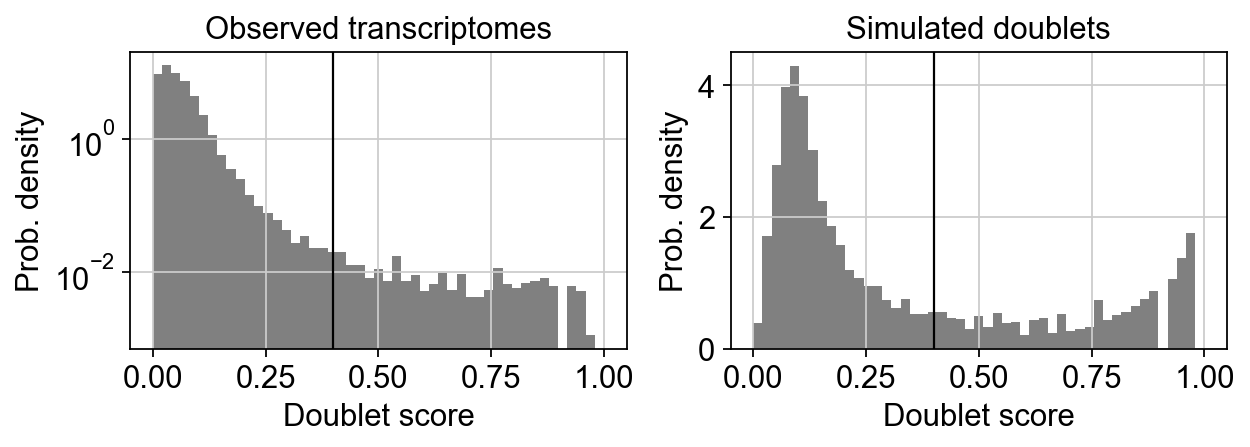

In [42]:
scrub.plot_histogram()

In [47]:
sum(Joanito_2022.obs['predicted_doublets'])

106

In [ ]:
# add in column with singlet/doublet instead of True/False
Joanito_2022.obs['doublet_info'] = Joanito_2022.obs["predicted_doublets"].astype(str)

In [48]:
#Saving the final anndata file
Joanito_2022.write('/Users/anna.maguza/Desktop/Data/Gut_project/Joanito_cancer/anndata/Joanito_raw_anndata_tumor_cells.h5ad')

### Filter by quality metrics

In [ ]:
#Filtering by genes
#Joanito_2022_anndata = Joanito_2022_anndata[Joanito_2022_anndata.obs.n_genes_by_counts < 4000, :]
#Joanito_2022_anndata = Joanito_2022_anndata[Joanito_2022_anndata.obs.n_genes_by_counts > 200, :]

#Filtering by counts
#Joanito_2022_anndata = Joanito_2022_anndata[Joanito_2022_anndata.obs.total_counts < 20000, :]